In [ ]:
!pip install tensorflow==1.14.0


In [ ]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.datasets import mnist

In [ ]:
# train the VAE on MNIST digits
noise_factor = 0.5
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
num_train=len(x_train)
num_test=len(x_test)
x_train = x_train.reshape((num_train, 28,28,1))
x_test = x_test.reshape((num_test, 28,28,1))
noise_train = x_train + noise_factor * np.random.randn(*x_train.shape)
noise_test = x_test + noise_factor * np.random.randn(*x_test.shape)
# Clip the images to be between 0 and 1
noise_train = np.clip(noise_train, 0., 1.).astype('float32')
noise_test = np.clip(noise_test, 0., 1.).astype('float32')

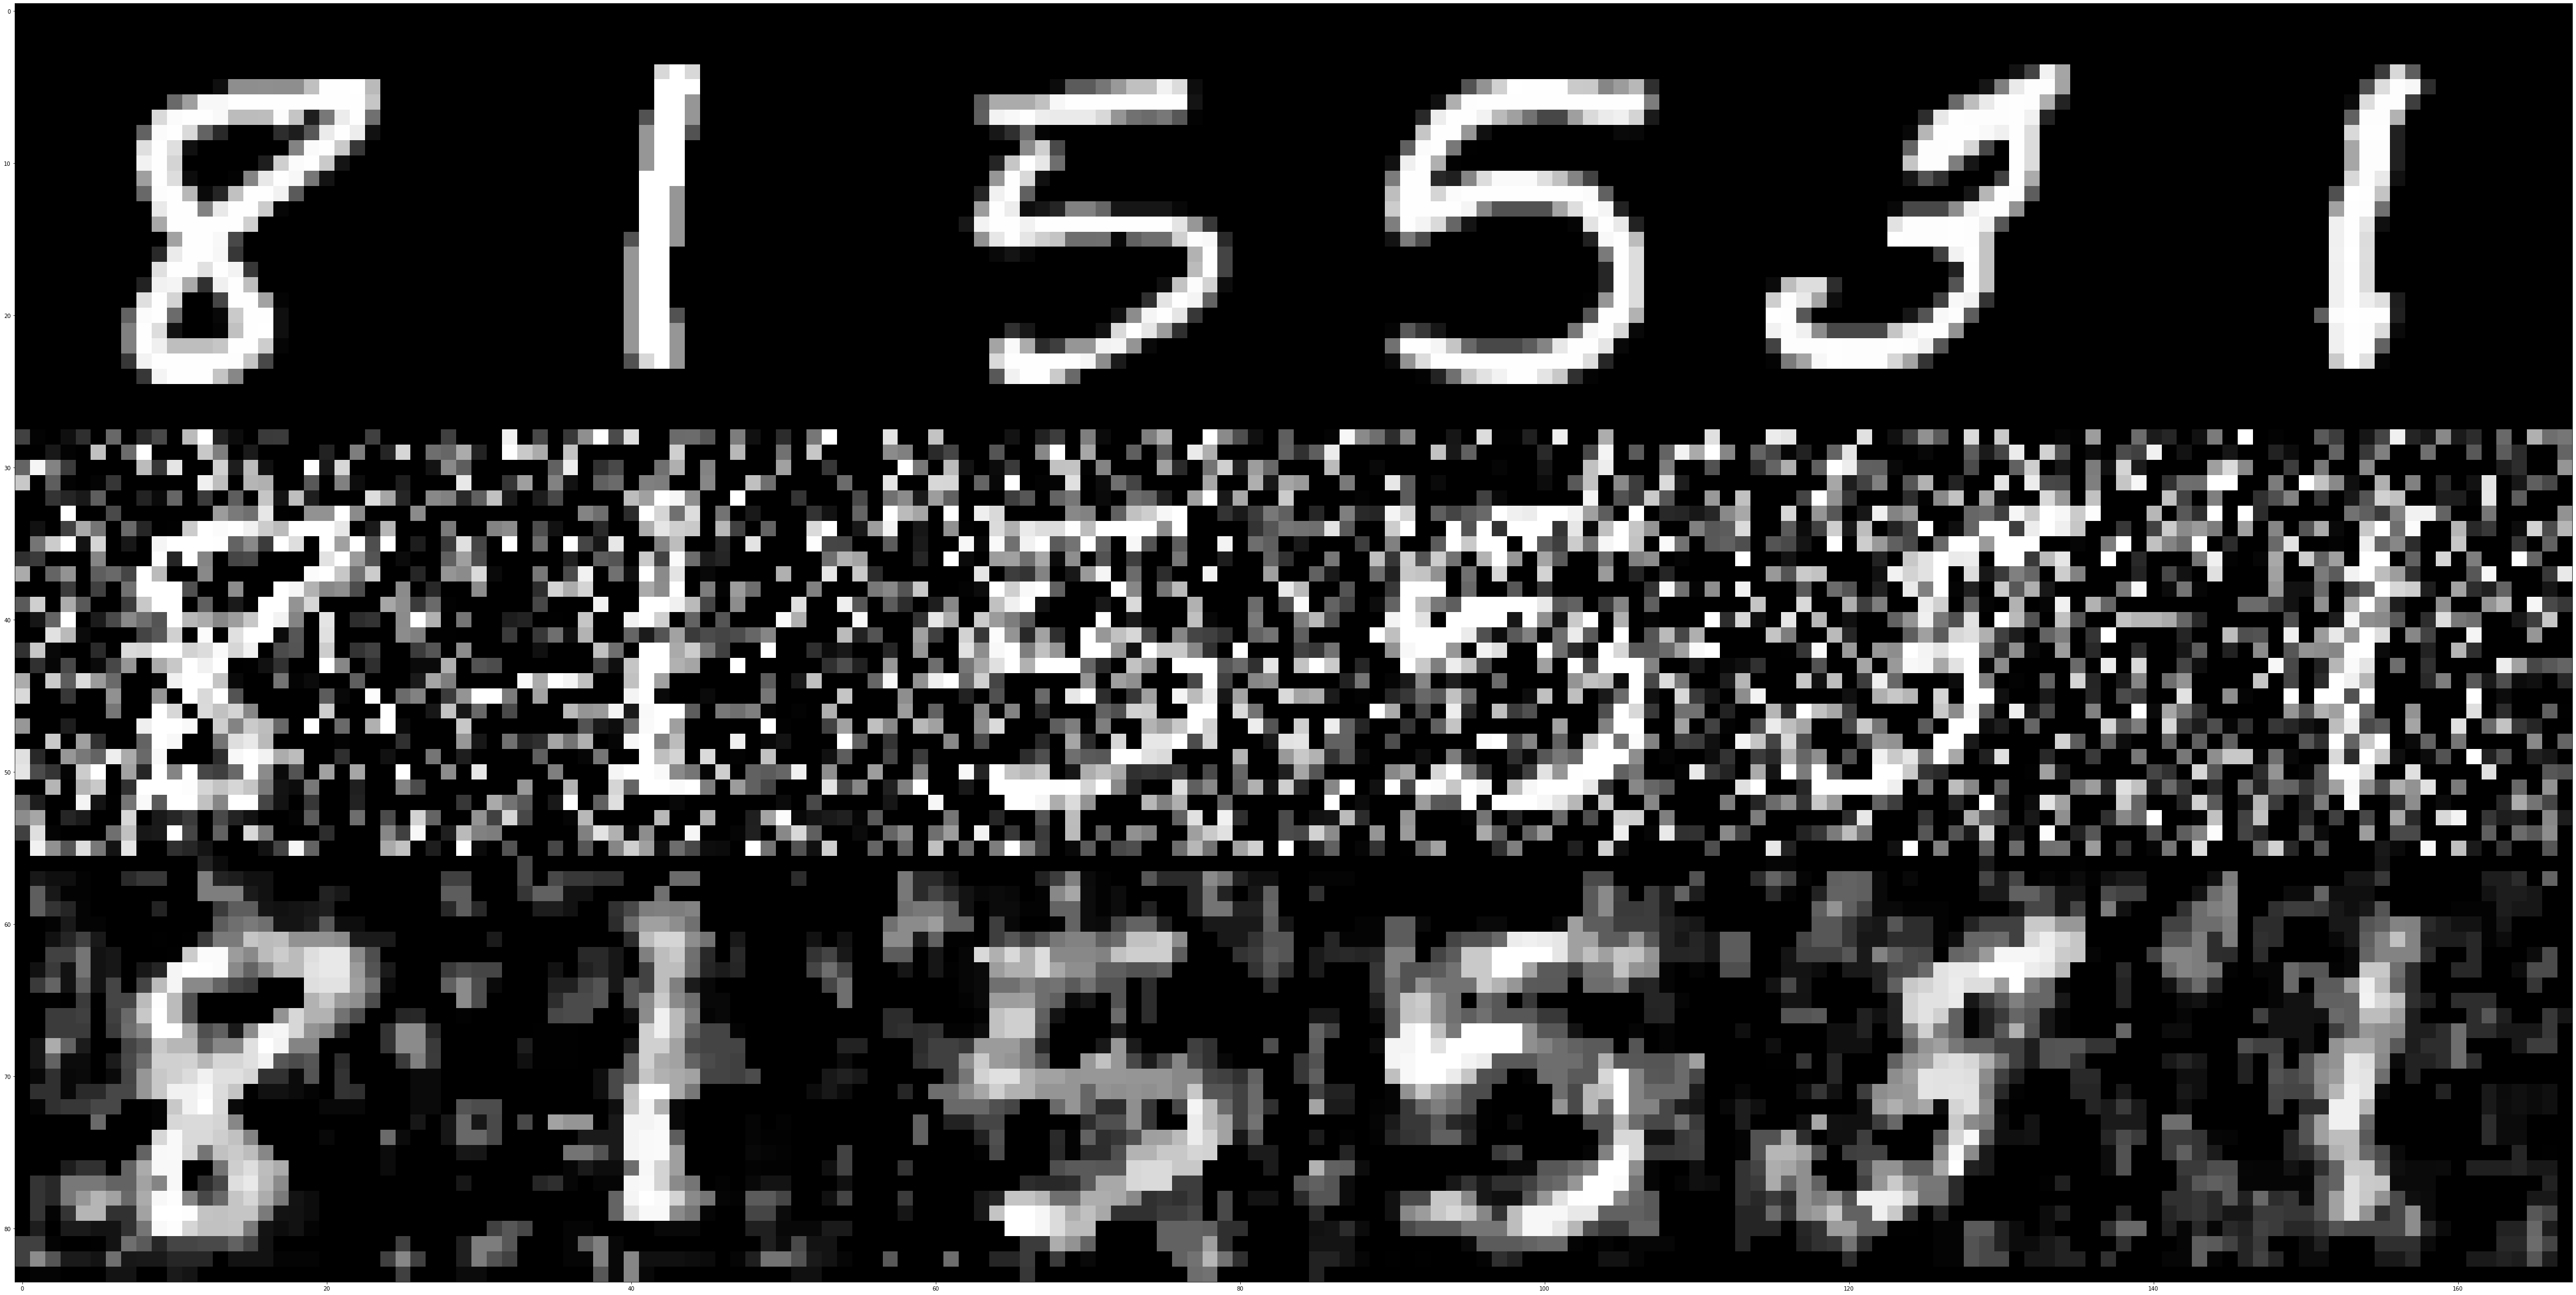

In [ ]:
n_images = 6
import scipy.signal as signal
figure = np.zeros((28*3 , 28 * n_images))
# Display
showidx=np.random.randint(0,num_train,n_images)
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_train[idx], [28, 28])
    figure[28: 56,i *28: (i + 1) * 28] = np.reshape(noise_train[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_train[idx], [28, 28]),[3,3])
plt.figure(figsize=(28*3, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
# Training Parameters
%matplotlib inline
learning_rate = 0.001
num_steps = 2500
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)

In [ ]:
# Create the neural network
def AE(x_dict, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('autoencoder', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['noise']
        
        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        conv1 = tf.layers.conv2d(x, 32, 3, activation=tf.nn.relu)
        conv2 = tf.layers.conv2d(conv1, 32, 3, activation=tf.nn.relu)
        pool1 = tf.layers.max_pooling2d(conv2, 2, 2)
        conv3 = tf.layers.conv2d(pool1, 64, 3, activation=tf.nn.relu)
        pool2 = tf.layers.max_pooling2d(conv3, 2, 2)
        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(pool2)
        fc1=tf.reshape(fc1,shape=[-1,1,1,1600])
        conv_0T = tf.layers.Conv2DTranspose(128,(1, 1),activation=tf.nn.relu)(fc1)#1*1
        conv_1T = tf.layers.Conv2DTranspose(64,(3, 3), activation=tf.nn.relu)(conv_0T)#3*3
        conv_2T = tf.layers.Conv2DTranspose(64,(3, 3), activation=tf.nn.relu)(conv_1T)#5*5
        conv_3T = tf.layers.Conv2DTranspose(48,(3, 3), strides=(2, 2),padding='same',activation=tf.nn.relu)(conv_2T)#10*10
        conv_4T = tf.layers.Conv2DTranspose(48,(3, 3), activation=tf.nn.relu)(conv_3T)#12*12
        conv_5T = tf.layers.Conv2DTranspose(32,(3, 3), strides=(2, 2),padding='same',activation=tf.nn.relu)(conv_4T)#24*24
        conv_6T = tf.layers.Conv2DTranspose(16,(3, 3), activation=tf.nn.relu)(conv_5T)#26*26
        out = tf.layers.Conv2DTranspose(1,(3, 3),activation=tf.nn.sigmoid)(conv_6T)#28*28
    #print(tf.layer.all_layers)
    return out

In [ ]:
def AE_loss(x_reconstructed,x_true):
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    return tf.reduce_mean(encode_decode_loss)

In [ ]:
# Define the model function (following TF Estimator Template)
def model_fn(features, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    decoder_train = AE(features, reuse=False, is_training=True)
    decoder_test = AE(features,reuse=True, is_training=False)
    
    flattendecoder=tf.reshape(decoder_train, shape=[-1, num_input, 1])
    flatteninput=tf.reshape(features['images'], shape=[-1, num_input, 1])
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=decoder_test) 
    
    # Define loss and optimizer
    #with tf.name_scope('Loss'):
    loss_op = AE_loss(flattendecoder,flatteninput)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    #acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    #tf.summary.scalar("loss", loss_op)
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      loss=loss_op,
      train_op=train_op,
      #eval_metric_ops={'accuracy': acc_op}
    )
    
    return estim_specs

In [ ]:
# Build the Estimator
#logs_path = '/tmp/tensorflow_logs/example/'
#summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp03p0mt4x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8731011c18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Define the input function for training

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images':x_train,'noise':noise_train},
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp03p0mt4x/model.ckpt.
INFO:tensorflow:loss = 543.4264, step = 1
INFO:tensorflow:global_step/sec: 1.99516
INFO:tensorflow:loss = 208.42664, step = 101 (50.124 sec)
INFO:tensorflow:global_step/sec: 2.00185
INFO:tensorflow:loss = 197.93427, step = 201 (49.953 sec)
INFO:tensorflow:global_step/sec: 2.00306
INFO:tensorflow:loss = 172.3943, step = 301 (49.926 sec)
INFO:tensorflow:global_step/sec: 2.00197
INFO:tensorflow:loss = 137.6627, step = 401 (49.949 sec)
INFO:tensorflow:global_step/sec: 2.00311
INFO:tensorflow:loss = 117.4396, step = 501 (49.922 sec)
INFO:tensorflow:global_step/sec: 1.93101
INFO:tensorflow:loss = 110.58569, step = 601 (51.786 sec)
INFO:tensorflow:global_step/sec: 1.99998
INFO:tensorflo

In [ ]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test,'noise': noise_test}, 
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-04-27T02:21:44Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp03p0mt4x/model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-04-27-02:21:59
INFO:tensorflow:Saving dict for global step 2500: global_step = 2500, loss = 79.04325
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2500: /tmp/tmp03p0mt4x/model.ckpt-2500


{'global_step': 2500, 'loss': 79.04325}

In [ ]:
print(num_test,n_images)

# Predict single images
# Get images from test set
showidx=np.random.randint(0,num_test,n_images)
test_images = x_test[showidx]
noise_images = noise_test[showidx]






10000 6


In [ ]:
figure = np.zeros((28 * 4, 28 * n_images))

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
query = x_test[7699]
#plt.imshow(query.reshape(28,28), cmap='gray')
X_test_new = np.delete(x_test, 7699, axis=0)
noise_test_new = np.delete(noise_test, 7699, axis=0)
print(X_test_new.shape)

# Prepare the input data
input_fn_new = tf.estimator.inputs.numpy_input_fn(
    x={'images': X_test_new,'noise': noise_test_new}, shuffle=False)
preds_new = list(model.predict(input_fn_new))


(9999, 28, 28, 1)
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp03p0mt4x/model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
noise_query = noise_test[7699]
#query
input_fn_new = tf.estimator.inputs.numpy_input_fn(
    x={'images': query,'noise': noise_query}, shuffle=False)
query_code = list(model.predict(input_fn_new))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp03p0mt4x/model.ckpt-2500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [ ]:
preds_new_np = np.array(preds_new)
query_code_np = np.array(query_code)
print(preds_new_np.shape)
print(query_code_np.shape)

(9999, 28, 28, 1)
(1, 28, 28, 1)


In [ ]:
from sklearn.neighbors import NearestNeighbors
n_neigh = 5
codes = preds_new_np.reshape(-1, 784); print(codes.shape)
#query_code = query_code.reshape(1, 4*4*8); print(query_code.shape)


(9999, 784)


In [ ]:
nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)


In [ ]:
query_codes = query_code_np.reshape(-1, 784); print(query_codes.shape)

(1, 784)


In [ ]:
distances, indices = nbrs.kneighbors(np.array(query_codes))
closest_images = x_test[indices]
closest_images = closest_images.reshape(-1,28,28,1); print(closest_images.shape)

(5, 28, 28, 1)


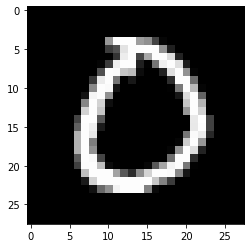

In [ ]:
plt.imshow(query.reshape(28,28), cmap='gray')

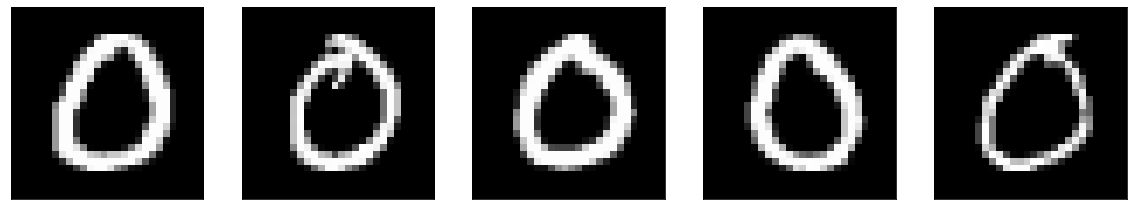

In [ ]:
plt.figure(figsize=(20, 6))
for i in range(n_neigh):
    # display original
    ax = plt.subplot(1, n_neigh, i+1)
    plt.imshow(closest_images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train_model, y_train_model), (x_test_model, y_test_model) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train_model = x_train_model.reshape(x_train_model.shape[0], 1, img_rows, img_cols)
    x_test_model = x_test_model.reshape(x_test_model.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_model = x_train_model.reshape(x_train_model.shape[0], img_rows, img_cols, 1)
    x_test_model = x_test_model.reshape(x_test_model.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train_model = x_train_model.astype('float32')
x_test_model = x_test_model.astype('float32')
x_train_model /= 255
x_test_model /= 255
print('x_train_model shape:', x_train_model.shape)
print(x_train_model.shape[0], 'train samples')
print(x_test_model.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train_model = keras.utils.to_categorical(y_train_model, num_classes)
y_test_model = keras.utils.to_categorical(y_test_model, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train_model, y_train_model,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test_model, y_test_model))
score = model.evaluate(x_test_model, y_test_model, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train_model shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 150s 2ms/step - loss: 0.2738 - accuracy: 0.9165 - val_loss: 0.0591 - val_accuracy: 0.9795
Epoch 2/12
60000/60000 [==============================] - 152s 3ms/step - loss: 0.0909 - accuracy: 0.9733 - val_loss: 0.0408 - val_accuracy: 0.9862
Epoch 3/12
60000/60000 [==============================] - 150s 2ms/step - loss: 0.0661 - accuracy: 0.9807 - val_loss: 0.0343 - val_accuracy: 0.9880
Epoch 4/12
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0552 - accuracy: 0.9837 - val_loss: 0.0268 - val_accuracy: 0.9914
Epoch 5/12
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0474 - accuracy: 0.9861 - val_loss: 0.0271 - val_accuracy: 0.9909
Epoch 6/12
60000/60000 [==============================] - 151s 3ms/step - loss: 0.0421 - accuracy: 0.9875 - val_loss: 0.0282 - val

In [ ]:
model.save("test_model.h5")

In [ ]:
def KNN(id, query_code):
  query = x_test[id]
  plt.imshow(query_code.reshape(28, 28))
  #plt.imshow(query.reshape(28,28), cmap='gray')
  X_test_new = np.delete(x_test, id, axis=0)
  noise_test_new = np.delete(noise_test, id, axis=0)
  print(X_test_new.shape)

   # Prepare the input data
  input_fn_new = tf.estimator.inputs.numpy_input_fn(
      x={'images': X_test_new,'noise': noise_test_new}, shuffle=False)
  preds_new = list(model.predict(input_fn_new))

  #noise_query = noise_test[id]
  #query
  #input_fn_new = tf.estimator.inputs.numpy_input_fn(
  #    x={'images': query,'noise': noise_query}, shuffle=False)
  #query_code = list(model.predict(input_fn_new))

  preds_new_np = np.array(preds_new)
  query_code_np = np.array(query_code)
  print(preds_new_np.shape)
  print(query_code_np.shape)

  from sklearn.neighbors import NearestNeighbors
  n_neigh = 10
  codes = preds_new_np.reshape(-1, 784); print(codes.shape)

  nbrs = NearestNeighbors(n_neighbors=n_neigh).fit(codes)
  query_codes = query_code_np.reshape(-1, 784); print(query_codes.shape)
  distances, indices = nbrs.kneighbors(np.array(query_codes))
  closest_images = x_test[indices]
  closest_images = closest_images.reshape(-1,28,28,1); print(closest_images.shape)

  plt.figure(figsize=(20, 6))
  for i in range(n_neigh):
      # display original
      ax = plt.subplot(1, n_neigh, i+1)
      plt.imshow(closest_images[i].reshape(28, 28))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
  plt.show()

In [ ]:
showidx=np.random.randint(0,num_test,n_images)
test_images = x_test[showidx[0]]
noise_images = noise_test[showidx[0]]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images,'noise': noise_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))
figure = np.zeros((28 * 4, 28 * n_images))
KNN(showidx[0],preds[0])

AttributeError: ignored

In [ ]:
# Predict single images
# Get images from test set
showidx=np.random.randint(0,num_test,n_images)
test_images = x_test[showidx]
noise_images = noise_test[showidx]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images,'noise': noise_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))
figure = np.zeros((28 * 4, 28 * n_images))
# Display
for i,idx in enumerate (showidx):
    figure[0: 28,i *28: (i + 1) * 28] = np.reshape(x_test[idx], [28, 28])
    figure[28: 28 * 2,i *28: (i + 1) * 28] = np.reshape(noise_test[idx], [28, 28])
    figure[28 * 2: 28 * 3,i *28: (i + 1) * 28] = np.reshape(preds[i], [28, 28])
    figure[28 * 3: 28 * 4,i *28: (i + 1) * 28] = signal.medfilt2d(np.reshape(noise_test[idx], [28, 28]),[3,3])
plt.figure(figsize=(28 * 4, 28*n_images))
plt.imshow(figure, cmap='Greys_r')
plt.savefig('result_tf_AE.png')
plt.show()

AttributeError: ignored